<a href="https://colab.research.google.com/github/sujitpal/keras-tutorial-osdc2020/blob/master/02_03_exercise_2_solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 2

In this exercise we will put together things that we have learned in this session. Our tasks are as follows:

* Build a transfer learning based classifier for the [CIFAR-10 dataset](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/cifar10) by combining the base layers of an [VGG-16 model trained on ImageNet](https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16) and a 2 layer Dense network.
  * Make sure the output of the VGG16 is followed by a BatchNorm layer, and the Dense layers have Dropouts.
* Train the network with transfer learning.
* Evaluate the performance of the model against the CIFAR-10 test set.
* Use the [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) to do data augmentation and retrain the network.
* Evaluate the performance again.
* Use the Learning Rate Finder to determine a good range of learning rates for the model (with data augmentation).
* Use a Cyclic Learning Rate (CLR) schedule to retrain the augmented transfer learning model.
* Evaluate the performance again.
* Present your findings.

__NOTE__: Make sure you have your runtime set to GPU for this notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras

%matplotlib inline

## Get the data

We have already seen the CIFAR-10 dataset. From [it's website](https://www.cs.toronto.edu/~kriz/cifar.html), it is a collection of (32, 32, 3) color images, with 50,000 images in its training set and 10,000 images in its test set.

In [2]:
CIFAR10_CLASSES = [
  "airplane", "automobile", "bird", "cat", "deer",
  "dog", "frog", "horse", "ship", "truck"
]

In [3]:
# TODO: get the data from Keras built-in datasets
(Xtrain, ytrain), (Xtest, ytest) = keras.datasets.cifar10.load_data()
print(Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [4]:
# TODO: convert training and test labels to categorical (one-hot) format
ytrain = keras.utils.to_categorical(ytrain, num_classes=len(CIFAR10_CLASSES))
ytest = keras.utils.to_categorical(ytest, num_classes=len(CIFAR10_CLASSES))

## Task 1: Build Transfer Learning Classifer

Download the pre-trained InceptionV3 network from `keras.applications`, set it up as a layer, and add in your 3-layer Dense network.

Remember to wrap the model in a `build_model` function, as you will be re-using the code to do this in later tasks as well.

Compile the model using the Adam optimizer, Categorical Cross Entropy loss, and Accuracy metric.

In [5]:
from keras.applications.vgg16 import VGG16, preprocess_input

# TODO: download pretrained Inception V3 network (include_top=False)
base_model = VGG16(weights="imagenet", input_shape=(32, 32, 3), include_top=False)

In [6]:
# TODO: preprocess the training and test images using the InceptionV3 means
Xtrain = preprocess_input(Xtrain)
Xtest = preprocess_input(Xtest)

In [7]:
# TODO: set up the model, remember to wrap this in a build_model() function.
def build_model():
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.2)(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  x = keras.layers.Dropout(0.2)(x)
  outputs = keras.layers.Dense(10, activation='softmax')(x)
  model = keras.models.Model(inputs=base_model.input, outputs=outputs)

# TODO: freeze the base model layers, i.e. make them non-trainable
  for layer in base_model.layers:
      layer.trainable = False

  return model


model_t1 = build_model()

In [8]:
# TODO: freeze the base model layers, i.e. make them non-trainable
#       consider lifting this code block into your build_model function.

In [9]:
# TODO: compile the model with Adam optimizer, Categorical Cross Entropy loss
#       and Accuracy metric.
model_t1.compile(optimizer="adam", loss="categorical_crossentropy", 
                 metrics=["accuracy"])

## Task 2: Train Network

Train the network for 50 epochs, using a batch size of 64. Use 20% of the training data for inline validation during the training.

In [10]:
# TODO: train network, save history for later
history_t1 = model_t1.fit(Xtrain, ytrain, batch_size=64, epochs=10, validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 9s 14ms/step - loss: 1.2614 - accuracy: 0.5708 - val_loss: 1.0290 - val_accuracy: 0.6357
Epoch 2/10
625/625 [==============================] - 9s 14ms/step - loss: 1.0545 - accuracy: 0.6299 - val_loss: 0.9675 - val_accuracy: 0.6617
Epoch 3/10
625/625 [==============================] - 9s 14ms/step - loss: 0.9693 - accuracy: 0.6557 - val_loss: 0.9394 - val_accuracy: 0.6757
Epoch 4/10
625/625 [==============================] - 8s 14ms/step - loss: 0.9108 - accuracy: 0.6799 - val_loss: 0.9231 - val_accuracy: 0.6847
Epoch 5/10
625/625 [==============================] - 8s 13ms/step - loss: 0.8594 - accuracy: 0.6966 - val_loss: 0.9278 - val_accuracy: 0.6815
Epoch 6/10
625/625 [==============================] - 8s 13ms/step - loss: 0.8197 - accuracy: 0.7090 - val_loss: 0.9317 - val_accuracy: 0.6879
Epoch 7/10
625/625 [==============================] - 8s 13ms/step - loss: 0.7706 - accuracy: 0.7243 - val_loss: 0.9350 - val_accuracy: 0.6829

In [11]:
def plot_training_curves(history):
  plt.figure(figsize=(10, 5))

  plt.subplot(1, 2, 1)
  plt.plot(history.history["loss"], label="train")
  plt.plot(history.history["val_loss"], label="validation")
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.legend(loc="best")

  plt.subplot(1, 2, 2)  
  plt.plot(history.history["accuracy"], label="train")
  plt.plot(history.history["val_accuracy"], label="validation")
  plt.xlabel("epochs")
  plt.ylabel("accuracy")
  plt.legend(loc="best")


  plt.tight_layout()
  _ = plt.show()

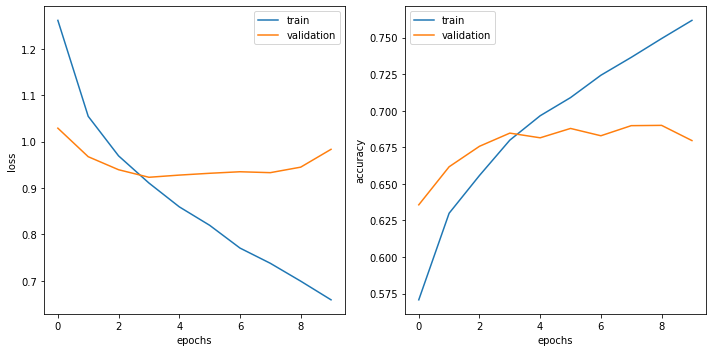

In [12]:
# TODO: plot the loss and accuracy plots for your training
plot_training_curves(history_t1)

## Task 3: Evaluate Network

Use the `model.evaluate()` function against the test set. First element in the returned array is the test loss, and second element is the test accuracy.

In [13]:
# TODO: evaluate the network you just trained
scores_t1 = model_t1.evaluate(Xtest, ytest)
print("Model T1: test set loss: {:.5f}, accuracy: {:.5f}".format(scores_t1[0], scores_t1[1]))

313/313 [==============================] - 3s 8ms/step - loss: 0.9803 - accuracy: 0.6823
Model T1: test set loss: 0.98028, accuracy: 0.68230


## Task 4: Augment Data and Retrain

Data Augmentor should have the following parameters at minimum, plus any you feel is relevant to your dataset. See [ImageDataGenerator docs](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) for full list of possible operations.

* rotation_range = 30
* width_shift_range = 0.2
* height_shift_range = 0.2
* horizontal_flip = True

In [14]:
from keras.preprocessing.image import ImageDataGenerator

# TODO: declare an image data generator that allows the operations listed
image_generator = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [15]:
# TODO: define model (again, reuse by calling the build_model function you defined earlier)
model_t2 = build_model()

# TODO: compile this new model (call this model_t2 to differentiate from previous model)
model_t2.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [16]:
from sklearn.model_selection import train_test_split

# TODO: split the training dataset 80/20 for training vs inline validation. This is 
#       because you don't want to get augmented versions of the validation set.
X_train, X_val, y_train, y_val = train_test_split(Xtrain, ytrain, test_size=0.2, random_state=1)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((40000, 32, 32, 3), (40000, 10), (10000, 32, 32, 3), (10000, 10))

In [17]:
# TODO: fit the model using the ImageDataGenerator, using batch size of 64 and
#       10 epochs of training.
history_t2 = model_t2.fit(image_generator.flow(X_train, y_train, batch_size=64),
                          steps_per_epoch=X_train.shape[0] // 64,
                          epochs=10,
                          validation_data=(X_val, y_val))

Epoch 1/10
625/625 [==============================] - 22s 35ms/step - loss: 1.4760 - accuracy: 0.4897 - val_loss: 1.1180 - val_accuracy: 0.6005
Epoch 2/10
625/625 [==============================] - 22s 35ms/step - loss: 1.2940 - accuracy: 0.5426 - val_loss: 1.0522 - val_accuracy: 0.6295
Epoch 3/10
625/625 [==============================] - 22s 35ms/step - loss: 1.2540 - accuracy: 0.5536 - val_loss: 1.0530 - val_accuracy: 0.6288
Epoch 4/10
625/625 [==============================] - 22s 35ms/step - loss: 1.2242 - accuracy: 0.5639 - val_loss: 1.0090 - val_accuracy: 0.6461
Epoch 5/10
625/625 [==============================] - 22s 35ms/step - loss: 1.1982 - accuracy: 0.5744 - val_loss: 1.0095 - val_accuracy: 0.6480
Epoch 6/10
625/625 [==============================] - 22s 35ms/step - loss: 1.1850 - accuracy: 0.5784 - val_loss: 0.9822 - val_accuracy: 0.6612
Epoch 7/10
625/625 [==============================] - 22s 36ms/step - loss: 1.1649 - accuracy: 0.5875 - val_loss: 0.9973 - val_accuracy:

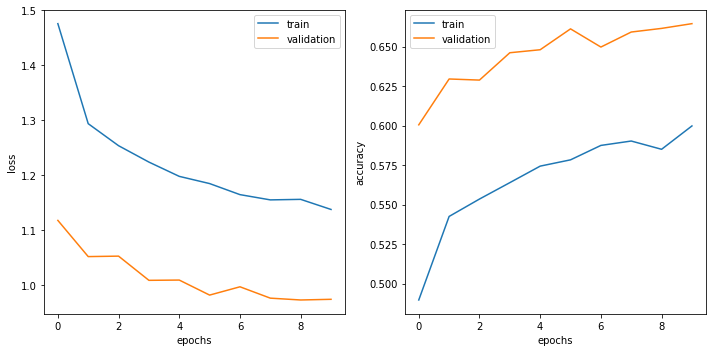

In [18]:
# TODO: plot the loss and accuracy plots for your training
plot_training_curves(history_t2)

## Task 5: Evaluate Performance

In [19]:
# TODO: evaluate the network you just trained
scores_t2 = model_t2.evaluate(Xtest, ytest)
print("Model T1: test set loss: {:.5f}, accuracy: {:.5f}".format(scores_t2[0], scores_t2[1]))

313/313 [==============================] - 3s 8ms/step - loss: 0.9947 - accuracy: 0.6600
Model T1: test set loss: 0.99466, accuracy: 0.66000


## Task 6: LR Finder

We want to find a good range for Learning Rates to use with our Cyclic Learning Rate schedule.

In [20]:
import math
from keras.callbacks import LambdaCallback
import numpy as np

class LRFinder:
    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        # lr = K.get_value(self.model.optimizer.lr)
        lr = keras.backend.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if batch > 5 and (math.isnan(loss) or loss > self.best_loss * 4):
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        # K.set_value(self.model.optimizer.lr, lr)
        keras.backend.set_value(self.model.optimizer.lr, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1, **kw_fit):
        # If x_train contains data for multiple inputs, use length of the first input.
        # Assumption: the first element in the list is single input; NOT a list of inputs.
        N = x_train[0].shape[0] if isinstance(x_train, list) else x_train.shape[0]

        # Compute number of batches and LR multiplier
        num_batches = epochs * N / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))
        # Save weights into a file
        initial_weights = self.model.get_weights()

        # Remember the original learning rate
        # original_lr = K.get_value(self.model.optimizer.lr)
        original_lr = keras.backend.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        # K.set_value(self.model.optimizer.lr, start_lr)
        keras.backend.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                       batch_size=batch_size, epochs=epochs,
                       callbacks=[callback],
                       **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.set_weights(initial_weights)

        # Restore the original learning rate
        # K.set_value(self.model.optimizer.lr, original_lr)
        keras.backend.set_value(self.model.optimizer.lr, original_lr)

    def find_generator(self, generator, start_lr, end_lr, epochs=1, steps_per_epoch=None, **kw_fit):
        if steps_per_epoch is None:
            try:
                steps_per_epoch = len(generator)
            except (ValueError, NotImplementedError) as e:
                raise e('`steps_per_epoch=None` is only valid for a'
                        ' generator based on the '
                        '`keras.utils.Sequence`'
                        ' class. Please specify `steps_per_epoch` '
                        'or use the `keras.utils.Sequence` class.')
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(epochs * steps_per_epoch))

        # Save weights into a file
        initial_weights = self.model.get_weights()

        # Remember the original learning rate
        # original_lr = K.get_value(self.model.optimizer.lr)
        original_lr = keras.backend.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        # K.set_value(self.model.optimizer.lr, start_lr)
        keras.backend.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch,
                                                      logs: self.on_batch_end(batch, logs))

        self.model.fit_generator(generator=generator,
                                 epochs=epochs,
                                 steps_per_epoch=steps_per_epoch,
                                 callbacks=[callback],
                                 **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.set_weights(initial_weights)

        # Restore the original learning rate
        # K.set_value(self.model.optimizer.lr, original_lr)
        keras.backend.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5, x_scale='log'):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale(x_scale)
        plt.show()

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        derivatives = self.get_derivatives(sma)[n_skip_beginning:-n_skip_end]
        lrs = self.lrs[n_skip_beginning:-n_skip_end]
        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(lrs, derivatives)
        plt.xscale('log')
        plt.ylim(y_lim)
        plt.show()

    def get_derivatives(self, sma):
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivatives.append((self.losses[i] - self.losses[i - sma]) / sma)
        return derivatives

    def get_best_lr(self, sma, n_skip_beginning=10, n_skip_end=5):
        derivatives = self.get_derivatives(sma)
        best_der_idx = np.argmin(derivatives[n_skip_beginning:-n_skip_end])
        return self.lrs[n_skip_beginning:-n_skip_end][best_der_idx]

In [21]:
# TODO: instantiate model and compile with optimizer="sgd"
model_lrf = build_model()
model_lrf.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"])

In [22]:
# TODO: instantiate the LRFinder and call find on it using a broad range of LR
#       and 5 epochs of training
lr_finder = LRFinder(model_lrf)
lr_finder.find(Xtrain, ytrain, start_lr=1e-7, end_lr=1, batch_size=64, epochs=5)

Epoch 1/5
782/782 [==============================] - 9s 12ms/step - loss: 2.6263 - accuracy: 0.1091
Epoch 2/5
782/782 [==============================] - 9s 12ms/step - loss: 2.6104 - accuracy: 0.1096
Epoch 3/5
782/782 [==============================] - 9s 12ms/step - loss: 2.3821 - accuracy: 0.1652
Epoch 4/5
782/782 [==============================] - 9s 12ms/step - loss: 1.5355 - accuracy: 0.4690
Epoch 5/5
782/782 [==============================] - 9s 12ms/step - loss: 1.3926 - accuracy: 0.5414


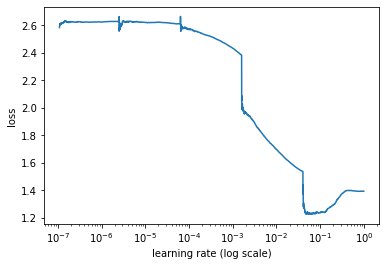

In [23]:
# TODO: plot the loss for LRFinder (call plot_loss())
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)

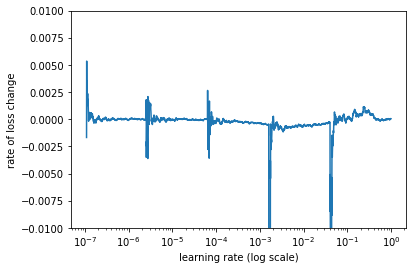

In [24]:
# TODO: plot the change of loss for LRFinder (call plot_loss_change())
lr_finder.plot_loss_change(sma=20, n_skip_beginning=20, n_skip_end=5, y_lim=(-0.01, 0.01))

Based on plots above, reasonable values for Learning Rate for CLR seem to be between 1e-3 and 1e-1.

## Task 7: Train with CLR

In [25]:
%%bash
(
if [ ! -d "CLR" ]; then
  git clone https://github.com/bckenstler/CLR
fi
)

In [26]:
from CLR.clr_callback import CyclicLR

batch_size = 128
step_size = 4 * Xtrain.shape[0] // batch_size
clr = CyclicLR(mode="triangular2",
               base_lr=1e-3,
               max_lr=1e-1,
               step_size=step_size)

In [27]:
# TODO: instantiate a model, compile with SGD optimizer, categorical cross entropy loss,
#       and accuracy metric, then train it for 10 epochs with batch size 64 and validation
#       split of 20%. Remember to set the CLR as your learning rate scheduler callback.
#       Also remember that you need to use data augmentation.
model_t3 = build_model()

model_t3.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"])
history_t3 = model_t3.fit(image_generator.flow(X_train, y_train, batch_size=64),
                          steps_per_epoch=X_train.shape[0] // 64,
                          epochs=10, 
                          validation_data=(X_val, y_val),
                          callbacks=[clr])

Epoch 1/10
625/625 [==============================] - 23s 37ms/step - loss: 1.7305 - accuracy: 0.3924 - val_loss: 1.1807 - val_accuracy: 0.5905
Epoch 2/10
625/625 [==============================] - 22s 36ms/step - loss: 1.4086 - accuracy: 0.5066 - val_loss: 1.1302 - val_accuracy: 0.5994
Epoch 3/10
625/625 [==============================] - 23s 36ms/step - loss: 1.3897 - accuracy: 0.5141 - val_loss: 1.1036 - val_accuracy: 0.6081
Epoch 4/10
625/625 [==============================] - 23s 36ms/step - loss: 1.2963 - accuracy: 0.5375 - val_loss: 1.0266 - val_accuracy: 0.6333
Epoch 5/10
625/625 [==============================] - 23s 36ms/step - loss: 1.2285 - accuracy: 0.5635 - val_loss: 1.0057 - val_accuracy: 0.6428
Epoch 6/10
625/625 [==============================] - 22s 36ms/step - loss: 1.2128 - accuracy: 0.5676 - val_loss: 1.0072 - val_accuracy: 0.6427
Epoch 7/10
625/625 [==============================] - 23s 36ms/step - loss: 1.2233 - accuracy: 0.5627 - val_loss: 1.0012 - val_accuracy:

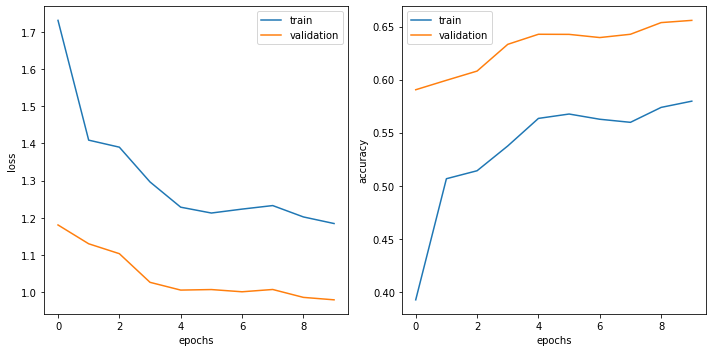

In [28]:
# TODO: plot the loss and accuracy plots for your training
plot_training_curves(history_t3)

## Task 8: Evaluate CLR based training

In [29]:
# TODO: evaluate the network you just trained
scores_t3 = model_t3.evaluate(Xtest, ytest)
print("Model T1: test set loss: {:.5f}, accuracy: {:.5f}".format(scores_t3[0], scores_t3[1]))

313/313 [==============================] - 3s 8ms/step - loss: 0.9923 - accuracy: 0.6554
Model T1: test set loss: 0.99228, accuracy: 0.65540


## Task 9: Summarize your findings

In [30]:
def plot_accuracies(methods, histories):
  train_accs, val_accs = [], []
  for method, history in zip(methods, histories):
    train_accs.append(history.history["accuracy"][-1])
    val_accs.append(history.history["val_accuracy"][-1])

  xs = np.arange(len(methods))
  width = 0.35
  plt.bar(xs, train_accs, width, color="b", label="train")
  plt.bar(xs+width, val_accs, width, color="orange", label="val")
  plt.axhline(y=train_accs[0], linestyle="--", color="b", xmin=0, xmax=1)
  plt.axhline(y=val_accs[0], linestyle="--", color="orange", xmin=0, xmax=1)
  plt.ylabel("accuracy")
  plt.xticks(xs, methods, rotation=90)
  plt.legend(loc="best")
  _ = plt.show()

def list_scores(methods, scores):
  for method, score in zip(methods, scores):
    print("{:s}: {:.5f}".format(method, score[1]))

In [31]:
tasks = ["vgg16", "vgg16+data", "vgg16+data+clr"]

# TODO: create a list of history and score objects similar to tasks above
histories = [history_t1, history_t2, history_t3]
scores = [scores_t1, scores_t2, scores_t3]

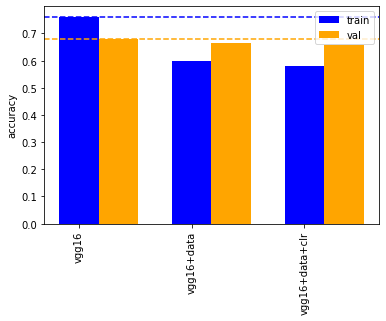

In [32]:
# TODO: plot the training and validation accuracies for each training;
#       call plot_accuracies()
plot_accuracies(tasks, histories)

In [33]:
# TODO: list final test set evaluation scores for each trained model;
#       call list_scores()
list_scores(tasks, scores)

vgg16: 0.68230
vgg16+data: 0.66000
vgg16+data+clr: 0.65540
